<a href="https://colab.research.google.com/github/1zuu/Machine-Learning-With-Graphs/blob/main/8_GNN_Tasks_CORA_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 2.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 709 kB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███

In [2]:
import torch, os
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch_geometric.utils.convert import to_networkx
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from itertools import combinations
from matplotlib import pyplot as plt

In [3]:
working_dir = '/content/drive/My Drive/Colab Notebooks/machine-learning-with-graphs/'
collection = 'Planetoid'
dataset = 'Cora'

data_dir = os.path.join(working_dir, collection)

In [4]:
data = Planetoid(
                root=data_dir, 
                name=dataset, 
                transform=NormalizeFeatures()
                )

Processing...
Done!


In [5]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)
print("No: of Graphs: ", len(data))


data0 = data[0]  # Get the first graph object.
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data0.num_nodes}')
print(f'Number of edges: {data0.num_edges}')
print(f'Average node degree: {data0.num_edges / data0.num_nodes:.2f}')
print(f'Has isolated nodes: {data0.has_isolated_nodes()}')
print(f'Has self-loops: {data0.has_self_loops()}')
print(f'Is undirected: {data0.is_undirected()}')

Dataset type:  <class 'torch_geometric.datasets.planetoid.Planetoid'>
Dataset features:  1433
Dataset target:  7
Dataset length:  <bound method InMemoryDataset.len of Cora()>
Dataset sample:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Sample  nodes:  2708
Sample  edges:  10556
No: of Graphs:  1
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## EACH NODE REPRESENT AS A EMBEDDING VECTOR WITH SIZE OF 1433 INDICES

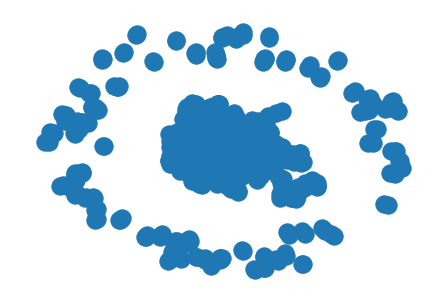

In [6]:
graph0 = to_networkx(data0, to_undirected=True)
nx.draw(graph0)

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=32):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize the layers
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer 
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [8]:
model = GCN()
model

GCN(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 32)
  (out): Linear(in_features=32, out_features=7, bias=True)
)

In [35]:
class NodeClassification(object):
    def __init__(self):
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
                                    model.parameters(), 
                                    lr = 0.01
                                    )  

        # Use GPU for training
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)

        self.X = data0.x.to(self.device)
        self.Y = data0.y.to(self.device)

        self.Xtrain = data0.x[data0.train_mask].to(self.device)  
        self.Ytrain = data0.y[data0.train_mask].to(self.device)  

        self.Xtest = data0.x[data0.test_mask].to(self.device)  
        self.Ytest = data0.y[data0.test_mask].to(self.device)  

        self.Xval = data0.x[data0.val_mask].to(self.device)  
        self.Yval = data0.y[data0.val_mask].to(self.device)

        self.edge_index = data0.edge_index.to(self.device)

    def train_epoch(self):
        self.model.train()
        self.optimizer.zero_grad() 

        pred = self.model(self.X, self.edge_index) 
        Ptrain = pred[data0.train_mask]

        loss = self.loss_fn(Ptrain, self.Ytrain)     
        loss.backward()  
        self.optimizer.step() 

        return loss, Ptrain

    def accuracy(self, y, p):
        p = p.detach().cpu().numpy().argmax(axis=-1)
        y = y.cpu().numpy()

        return np.mean(p == y)

    def train(self, epoches = 2000):
        print("Starting training...")
        losses = []
        val_losses = []
        for epoch in range(epoches + 1):
            loss, Ptrain = self.train_epoch()
            loss = round(loss.item(), 3)  
            train_acc = round(self.accuracy(self.Ytrain, Ptrain), 3)  
            losses.append(loss)
            if epoch % 100 == 0:
                with torch.no_grad():
                    pred = self.model(self.X, self.edge_index) 
                    Pval = pred[data0.val_mask]
                    val_loss = round(self.loss_fn(Pval, self.Yval).item(), 3)   
                    val_acc = round(self.accuracy(self.Yval, Pval), 3)  
                    val_losses.append(val_loss)
                print(f"Epoch {epoch} | Train Loss {loss} | Val Loss {val_loss} | Train Acc {train_acc} | Val Acc {val_acc}")

In [36]:
classifier = NodeClassification()
classifier.train()

Starting training...
Epoch 0 | Train Loss 1.168 | Val Loss 1.435 | Train Acc 1.0 | Val Acc 0.724
Epoch 100 | Train Loss 1.166 | Val Loss 1.466 | Train Acc 1.0 | Val Acc 0.7
Epoch 200 | Train Loss 1.166 | Val Loss 1.453 | Train Acc 1.0 | Val Acc 0.714
Epoch 300 | Train Loss 1.171 | Val Loss 1.465 | Train Acc 0.993 | Val Acc 0.688
Epoch 400 | Train Loss 1.167 | Val Loss 1.456 | Train Acc 1.0 | Val Acc 0.702
Epoch 500 | Train Loss 1.166 | Val Loss 1.467 | Train Acc 1.0 | Val Acc 0.7
Epoch 600 | Train Loss 1.171 | Val Loss 1.441 | Train Acc 0.993 | Val Acc 0.732
Epoch 700 | Train Loss 1.166 | Val Loss 1.439 | Train Acc 1.0 | Val Acc 0.728
Epoch 800 | Train Loss 1.166 | Val Loss 1.437 | Train Acc 1.0 | Val Acc 0.728
Epoch 900 | Train Loss 1.178 | Val Loss 1.465 | Train Acc 0.986 | Val Acc 0.702
Epoch 1000 | Train Loss 1.169 | Val Loss 1.454 | Train Acc 1.0 | Val Acc 0.708
Epoch 1100 | Train Loss 1.171 | Val Loss 1.473 | Train Acc 0.993 | Val Acc 0.69
Epoch 1200 | Train Loss 1.166 | Val Loss